In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch_geometric.data as data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

from networkit import *
import networkx as nx
import nxviz as nv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import f1_score

import torch
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch.nn.functional import normalize
from torch_geometric.datasets import WebKB, StochasticBlockModelDataset
from torch_geometric.utils import negative_sampling, to_networkx, to_dense_adj
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GraphConv, TransformerConv   
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

/home/siddy/anaconda3/envs/GDL/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#dataset = WebKB(root="/home/siddy/META/data", name='cornell')
dataset = StochasticBlockModelDataset(root="/home/siddy/META/data", block_sizes=[10,10], edge_probs=[[0.3, 0.1], [0.1, 0.3]], is_undirected=True)
data = dataset[0].to(device)

In [4]:
data

Data(edge_index=[2, 66], y=[20])

/home/siddy/anaconda3/envs/GDL/lib/python3.8/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


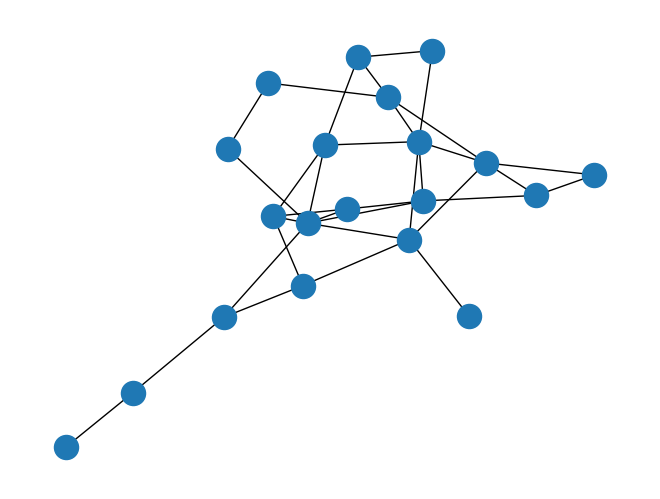

In [5]:
G = to_networkx(data, to_undirected=True)
nx.draw(G, pos=nx.spring_layout(G))

In [6]:
A_initial = to_dense_adj(data.edge_index)

In [7]:
def neg_index(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index
    
    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.long)
    for i in range(edge_index.size(1)):
        u, v = int(edge_index[0, i]), int(edge_index[1, i])
        adj_matrix[u, v] = 1
        adj_matrix[v, u] = 1

    neg_indices = []
    for i in range(edge_index.size(1)):
        u, v = int(edge_index[0, i]), int(edge_index[1, i])
        adj_squared = torch.mm(adj_matrix, adj_matrix)
        adj_row_u = adj_matrix[u]
        adj_row_v = adj_matrix[v]
        bitwise_and_result = torch.bitwise_and(adj_squared[u], adj_squared[v])
        sum_bitwise_and_result = torch.sum(bitwise_and_result)
        sum_adj_u = torch.sum(adj_row_u)
        sum_adj_v = torch.sum(adj_row_v)
        neg_index = sum_bitwise_and_result.float() / (sum_adj_u + sum_adj_v)
        neg_indices.append(neg_index.item())

    return neg_indices

In [8]:
def pos_index(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index

    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.long)
    for i in range(edge_index.size(1)):
        u, v = int(edge_index[0, i]), int(edge_index[1, i])
        adj_matrix[u, v] = 1
        adj_matrix[v, u] = 1

    pos_indices = []
    for i in range(edge_index.size(1)):
        u, v = int(edge_index[0, i]), int(edge_index[1, i])
        adj_row_u = adj_matrix[u]
        adj_row_v = adj_matrix[v]
        bitwise_and_result = torch.bitwise_and(adj_row_u, adj_row_v)
        sum_bitwise_and_result = torch.sum(bitwise_and_result)
        sum_adj_u = torch.sum(adj_row_u)
        sum_adj_v = torch.sum(adj_row_v)
        pos_index = sum_bitwise_and_result.float() / (sum_adj_u + sum_adj_v)
        pos_indices.append(pos_index.item())

    return pos_indices

In [26]:
import torch
from torch_geometric.data import Data
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch import settings
from botorch.posteriors.torch import TorchPosterior
from torch.distributions.kl import kl_divergence
from torch.distributions.categorical import Categorical
#from botorch.models.transforms import AffineTransform
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms import Standardize, Normalize
from botorch.posteriors.gpytorch import scalarize_posterior_gpytorch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
BATCH_SIZE =1
NUM_RESTARTS=2
RAW_SAMPLES=4
d = 20
bounds_ = torch.tensor([[-6.0] * d, [6.0] * d], device=device, dtype=dtype)


def optimize_acqf_and_get_observation(acq_func):
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.stack(
            [
                torch.zeros(d, dtype=dtype, device=device),
                torch.ones(d, dtype=dtype, device=device),
            ]
        ),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = score_image(decode(new_x)).unsqueeze(-1)
    return new_x, new_obj

def create_variational_matrix_bayesian(data, num_nodes, edge_index):

    dtype = torch.float
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    variational_matrix = torch.nn.Parameter(torch.rand((num_nodes, num_nodes), dtype=dtype, device=device))
    num_iterations = 20

    def custom_objective(sample):
        sigma_1, sigma_2 = sample
        for s1 in sigma_1:
            (s1- 0.5)**2
        return sigma_1 + sigma_2
        
    settings.device = device
    bounds = torch.tensor([[0.0, 1.0], [0.0, 1.0]], dtype=dtype, device=device)
    constraint = torch.tensor([[0.0, 0.0]], dtype=dtype, device=device)

    #train_x = torch.zeros(1, 2, dtype=dtype, device=device)
    train_x = variational_matrix
    #train_obj = torch.zeros(1, 1, dtype=dtype, device=device)
    sigma_2 = pos_index(data)
    sigma_1 = neg_index(data)
    sample = sigma_1, sigma_2
    # custom objective
    train_obj = torch.tensor(custom_objective(sample))
    # Must specify a posterior transform when using a multi-output model
    # connecting posterior distribution to s1, s2
    #distribution = kl_divergence(sigma_1, sigma_2)
    #distribution = Categorical(probs=A_initial)
    #posterior_transform = TorchPosterior(distribution)
    #posterior_transform = AffineTransform(scale=2.0, shift=1.0)
    model = SingleTaskGP(train_x, train_obj.unsqueeze(0))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    for _ in range(num_iterations):
        fit_gpytorch_model(mll)
        qEI = qExpectedImprovement(model,objective=custom_objective, best_f=train_obj.max())

        # bounds_ = torch.stack([bounds[:, 0], bounds[:, 1]]).transpose(0, 1)
        new_x, new_obj = optimize_acqf_and_get_observation(qEI)

        #update training points
        train_x = torch.cat((train_x, new_x),-1)
        train_obj = torch.cat((train_obj, new_obj),-1)
        #variational_matrix.data = torch.tensor([[sigma_1, sigma_2]], dtype=dtype, device=device)

        # update progress
        utility_value = train_obj.max().item()
        

        print(f"Iteration {_ + 1}/{num_iterations}: Utility Value: {utility_value.item()}")

    return variational_matrix, new_point

In [27]:
generated_adjacency_matrix, new_point= create_variational_matrix_bayesian(data, data.num_nodes, data.edge_index)

/home/siddy/anaconda3/envs/GDL/lib/python3.8/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/siddy/anaconda3/envs/GDL/lib/python3.8/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/siddy/anaconda3/envs/GDL/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


RuntimeError: Flattening the training labels failed. The most common cause of this error is that the shapes of the prior mean and the training labels are mismatched. The shape of the train targets is torch.Size([132, 1]), while the reported shape of the mean is torch.Size([132, 20]).

In [60]:
adjacency_matrix_binary = (generated_adjacency_matrix > 0.7).float()

In [61]:
adjacency_matrix_binary.shape

torch.Size([20, 20])

In [62]:
G_hat = nx.from_numpy_array(adjacency_matrix_binary.detach().cpu().numpy())

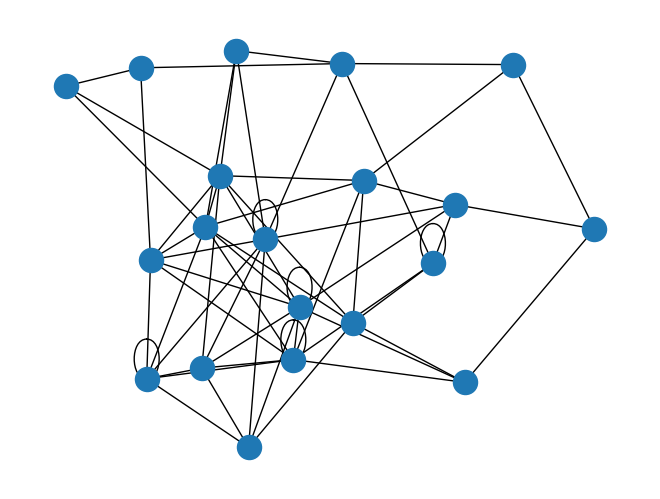

In [63]:
nx.draw(G_hat, pos=nx.spring_layout(G_hat))

In [ ]:
# Create a sample data object (Replace this with your actual data)
num_nodes = 10
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3],
                           [1, 0, 2, 1, 3, 2]], dtype=torch.long)
data = Data(num_nodes=num_nodes, edge_index=edge_index)

# Create the variational matrix using Bayesian optimization
generated_variational_matrix = create_variational_matrix_bayesian(data, num_nodes, edge_index)

print("Generated Variational Matrix:")
print(generated_variational_matrix)